In [2]:
import numpy as np 
import pandas as pd 

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px

**Load data from csv files.**

Information about types of brain waves (especially low vs high): https://nhahealth.com/brainwaves-the-language/

In [5]:
sleepiness_df = pd.read_csv("C:/SEAN/GA Tech Academics/Grad/Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Sleepiness/Datasets/acquiredDataset.csv", header = 0)

In [5]:
sleepiness_df.head()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750,0
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251,0
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825,0
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471,0


Drop the rightmost column of sleepiness_df, because we are more concerned with attention and meditation.

In [6]:
sleepiness_df = sleepiness_df.iloc[:, :-1]

In [7]:
print(sleepiness_df.shape)

(3735, 10)


In [8]:
sleepiness_df.head()

,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471


**Visualize the raw data.**

<Axes: >

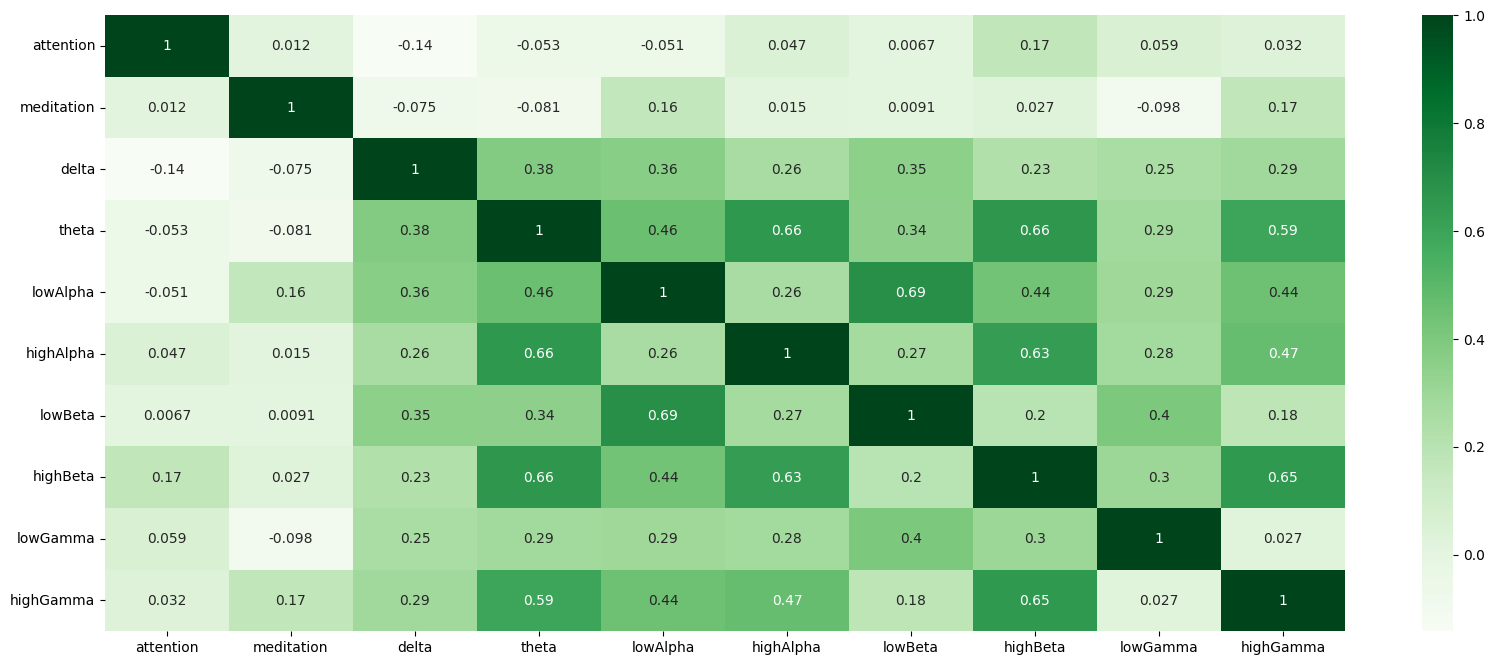

In [9]:
plt.figure(figsize=(20, 8))
sns.heatmap(sleepiness_df.corr(), cmap="Greens", annot=True)

**Data preprocessing:**

Helpful links about determining optimal polynomial order for regression:

https://aamir07.medium.com/polynomial-regression-with-k-fold-cross-validation-bc5275137546

We have two output variables we want to study- attention and meditation. We will handle each of them separately.

In [8]:
X = sleepiness_df.iloc[:, 2:]
X.head()

,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma
0,960462,277180,26575,27356,26575,13056,9126,2683
1,39145,28225,20172,39551,20172,9933,5237,4750
2,75410,43144,8601,13564,8601,11663,2515,3251
3,16057,41211,2534,34254,2534,27663,11396,2825
4,10304,47239,33158,47349,33158,16328,5298,5471


In [12]:
def perform_feature_selection(X: pd.DataFrame, y) -> pd.DataFrame:
    
    # Use recursive feature elimination to select the best features from X
    rfecv = RFECV(estimator = LinearRegression(), min_features_to_select = 1, scoring = 'neg_root_mean_squared_error', cv = 5)
    rfecv.fit(X, y)
    kept_columns = X.columns[rfecv.support_]
    
    print("kept columns:")
    print(kept_columns)
    return X.loc[:, kept_columns]

In [162]:
def k_folds_cross_validation(X: pd.DataFrame, y) -> int:
    training_errors = []
    cross_validation_errors = []

    for i in range(1, 8): # Experiment with degrees of 1 (linear) up to 7
        #print("i =", i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
        linear_reg = LinearRegression(fit_intercept=False)
        model = linear_reg.fit(X_train, y_train)

        # Predict on test data and compute RMSE
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        training_errors.append(rmse)

        # Perform 5-fold cross-validation and compute mean RMSE
        cv = cross_validate(linear_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, return_train_score=True)
        #print(cv['test_score'])
        mean_cv_rmse = np.sqrt(np.abs(np.mean(cv['test_score'])))
        cross_validation_errors.append(mean_cv_rmse)

    # Visualize the training and cross-validation errors for each polynomial degree
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(1, 8), cross_validation_errors, label='Cross-Validation RMSE', marker='o')
    ax.set_xlabel('Polynomial Degree', fontsize=16)
    ax.set_ylabel('RMSE', fontsize=16)
    ax.set_title('Cross-Validation RMSE', fontsize=18)
    ax.legend(fontsize=12)
    plt.show()
    
    optimal_degree = np.argmin(cross_validation_errors) + 1  # Add 1 because degrees start at 1
    return optimal_degree

**Implement the regression models.**

Helpful links:

https://data36.com/polynomial-regression-python-scikit-learn/

https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/

**Regression model for attention:**

In [10]:
y_attention = sleepiness_df.iloc[:, 0]
y_attention.head()

0    26
1    29
2    40
3    66
4    81
Name: attention, dtype: int64

In [30]:
X_attention_preprocessed = perform_feature_selection(X, y_attention)

kept columns:
Index(['theta', 'lowAlpha', 'highAlpha', 'lowBeta', 'highBeta', 'lowGamma'], dtype='object')


In [31]:
X_attention_preprocessed.head()

,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma
0,277180,26575,27356,26575,13056,9126
1,28225,20172,39551,20172,9933,5237
2,43144,8601,13564,8601,11663,2515
3,41211,2534,34254,2534,27663,11396
4,47239,33158,47349,33158,16328,5298


In [53]:
# This function reformats millions for easier display (e.g. 3,000,000 -> 3M)
def reformat_millions(x, pos):
    return f'{x * 1e-6:.1f}M'  

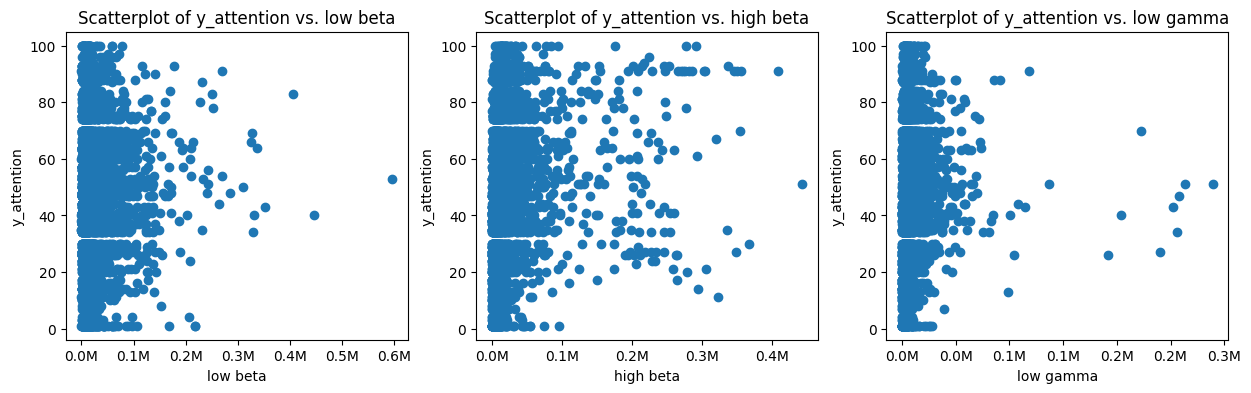

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i, label in enumerate(['low beta', 'high beta', 'low gamma']):
    axes[i].scatter(X_attention_preprocessed.iloc[:, i + 3], y_attention)
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('y_attention')
    axes[i].set_title(f'Scatterplot of y_attention vs. {label}')
    axes[i].xaxis.set_major_formatter(FuncFormatter(reformat_millions))  # Format x-axis ticks

plt.show()

Now implement the regression model for attention.

In [121]:
attention_poly = PolynomialFeatures(degree = 2, include_bias = False)
attention_poly_features = attention_poly.fit_transform(X_attention_preprocessed)

In [122]:
# Split the dataset into 80% for training and 20% for testing
X_attention_train, X_attention_test, y_attention_train, y_attention_test = train_test_split(attention_poly_features, y_attention, test_size = 0.2)

In [123]:
attention_poly_model = LinearRegression()
attention_poly_model.fit(X_attention_train, y_attention_train)

LinearRegression()

In [124]:
attention_poly_y_pred = attention_poly_model.predict(X_attention_test)

In [134]:
# Calculate RMSE and R^2 Score
attention_poly_rmse = root_mean_squared_error(y_attention_test, attention_poly_y_pred)
attention_poly_r2 = r2_score(y_attention_test, attention_poly_y_pred)

# Print the results
print(f"Root Mean Squared Error (RMSE): {attention_poly_rmse:.4f}")
print(f"R^2 Score: {attention_poly_r2:.4f}")
# print("Model Coefficients:")
# for i, coef in enumerate(attention_poly_model.coef_):
#     print(f"  Coefficient for feature {i + 1}: {coef}")

Root Mean Squared Error (RMSE): 20.2560
R^2 Score: 0.1614


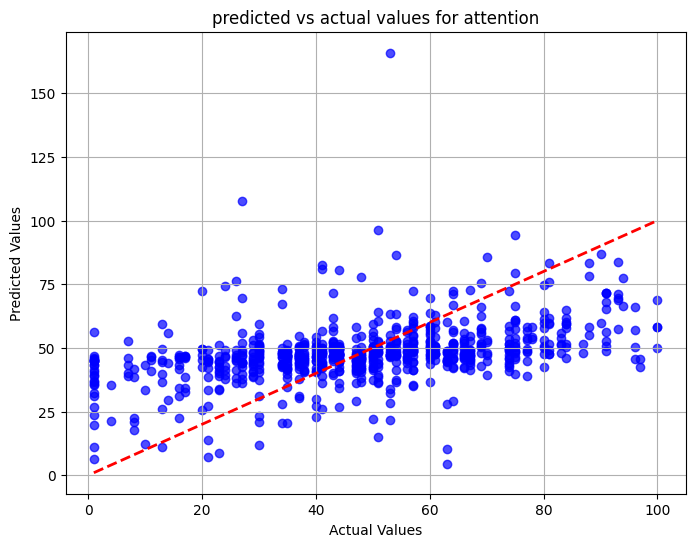

In [135]:
# Plotting Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_attention_test, attention_poly_y_pred, alpha=0.7, color='blue')
plt.plot([y_attention_test.min(), y_attention_test.max()], 
         [y_attention_test.min(), y_attention_test.max()], 
         color='red', lw=2, linestyle='--')  # red = prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('predicted vs actual values for attention')
plt.grid(True)
plt.show()

**Regression model for meditation:**

In [33]:
y_meditation= sleepiness_df.iloc[:, 1]
y_meditation.head()

0    34
1    54
2    48
3    47
4    67
Name: meditation, dtype: int64

In [34]:
X_meditation_preprocessed = perform_feature_selection(X, y_meditation)

kept columns:
Index(['theta', 'lowAlpha', 'highAlpha', 'lowBeta', 'lowGamma'], dtype='object')


In [35]:
X_meditation_preprocessed.head()

,theta,lowAlpha,highAlpha,lowBeta,lowGamma
0,277180,26575,27356,26575,9126
1,28225,20172,39551,20172,5237
2,43144,8601,13564,8601,2515
3,41211,2534,34254,2534,11396
4,47239,33158,47349,33158,5298


Scatterplot of y_meditation vs theta

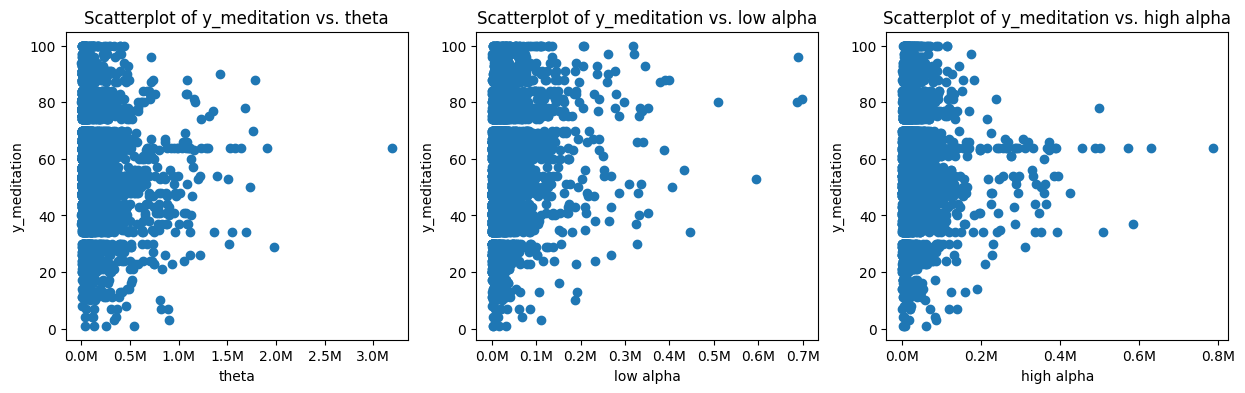

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i, label in enumerate(['theta', 'low alpha', 'high alpha']):
    axes[i].scatter(X_meditation_preprocessed.iloc[:, i], y_meditation)
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('y_meditation')
    axes[i].set_title(f'Scatterplot of y_meditation vs. {label}')
    axes[i].xaxis.set_major_formatter(FuncFormatter(reformat_millions))  # Format x-axis ticks

plt.show()

Now implement the regression model for meditation.

In [176]:
meditation_poly = PolynomialFeatures(degree = 2, include_bias = False)
meditation_poly_features = meditation_poly.fit_transform(X_meditation_preprocessed)

In [177]:
# Split the dataset into 80% for training and 20% for testing
X_meditation_train, X_meditation_test, y_meditation_train, y_meditation_test = train_test_split(meditation_poly_features, y_meditation, test_size = 0.2)

In [178]:
meditation_poly_model = LinearRegression()
meditation_poly_model.fit(X_meditation_train, y_meditation_train)

LinearRegression()

In [179]:
meditation_poly_y_pred = meditation_poly_model.predict(X_meditation_test)

In [180]:
# Calculate RMSE and R^2 Score
meditation_poly_rmse = root_mean_squared_error(y_meditation_test, meditation_poly_y_pred)
meditation_poly_r2 = r2_score(y_meditation_test, meditation_poly_y_pred)

# Print the results
print(f"Root Mean Squared Error (RMSE): {meditation_poly_rmse:.4f}")
print(f"R^2 Score: {meditation_poly_r2:.4f}")

Root Mean Squared Error (RMSE): 17.2177
R^2 Score: 0.1694


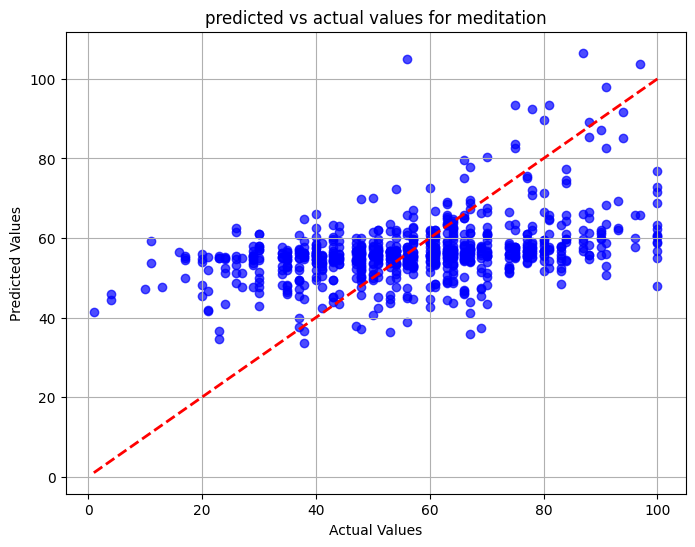

In [181]:
# Plotting Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_meditation_test, meditation_poly_y_pred, alpha=0.7, color='blue')
plt.plot([y_meditation_test.min(), y_meditation_test.max()], 
         [y_meditation_test.min(), y_meditation_test.max()], 
         color='red', lw=2, linestyle='--')  # red = prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('predicted vs actual values for meditation')
plt.grid(True)
plt.show()